### Comparing Regression Models
In this notebook, we'll look at methods for comparing regression models.  In this notebook, we'll use results from the paper [Validation of AMBER/GAFF for Relative Free Energy Calculations](https://chemrxiv.org/articles/Validation_of_AMBER_GAFF_for_Relative_Free_Energy_Calculations/7653434) to compare two different approaches to free energy calculations.  More information can be found in this [blog post](http://practicalcheminformatics.blogspot.com/2019/02/some-thoughts-on-evaluating-predictive.html). 

Install the necessary Python libraries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pandas matplotlib seaborn numpy scipy scikit-learn

Import the necessary Python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import norm, pearsonr
from sklearn.metrics import mean_squared_error
import warnings

#### Read and Parse the Input Data
As a first step, we want to grab the data from a set of Excel worksheets in the supporting material.  The Excel workbook has multiple sheets, we need to get the names of those sheets. Fortunately Pandas has all sorts of facilities for manipulating Excel files.

In [2]:
xls_name = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/FEP_vs_GTI-dG-SI.xlsx"
df_dict = pd.read_excel(xls_name,sheet_name=None,header=None)

Now we can define a function that will grab the data from a particular sheet. In this case the data we want is in columns 15-17. We'll grab those columns and create a new dataframe with the columns labeled as Experimental  Δ G, FEP  Δ G, and TI  Δ G. We will also include columns with the target and with the target concatenated with a sequential index. Ok, in truth, we're going to label the columns as Experimental_dG, etc. for convenience.  The final row in columns 15-17 is the sum of the values in the column.  We don't want this, so we'll use df = df.query("Experimental_dG > -20") to get rid of the sum row.

In [3]:
def get_data_from_sheet(df_dict, sheet_name, col_names):
    df = df_dict[sheet_name]
    df = df[df.columns[15:18]]
    col_names = ["Experimental_dG","FEP_dG","TI_dG"]
    df.columns = col_names
    df = df.dropna()
    df = df.query("Experimental_dG > -20")
    rows,_ = df.shape
    df.insert(0,"Target",[sheet_name]*rows)
    df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
    return df

Define the number of decimal places displayed in the Pandas table.

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

Read the Excel sheets and put the data into a Pandas dataframe.

In [5]:
sheet_names = df_dict.keys()
col_names = ["Experimental_dG","FEP_dG","TI_dG"]
big_df = pd.DataFrame(columns=["Target","ID"]+col_names)
for sheet in sheet_names:
    tmp_df = get_data_from_sheet(df_dict,sheet,col_names)
    big_df = big_df.append(tmp_df)   
big_df.sort_values("Target",inplace=True)

/var/folders/mf/pm2p2q1s4gzbtyyz1cxhlpyc0000gn/T/ipykernel_30927/2245923024.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(tmp_df)
/var/folders/mf/pm2p2q1s4gzbtyyz1cxhlpyc0000gn/T/ipykernel_30927/2245923024.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(tmp_df)
/var/folders/mf/pm2p2q1s4gzbtyyz1cxhlpyc0000gn/T/ipykernel_30927/2245923024.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(tmp_df)
/var/folders/mf/pm2p2q1s4gzbtyyz1cxhlpyc0000gn/T/ipykernel_30927/2245923024.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(tmp_df)
/var/fol

In [6]:
big_df.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG
12,bace,bace_12,-8.53,-6.76,-8.27
30,bace,bace_30,-7.84,-7.40,-7.40
29,bace,bace_29,-9.01,-7.93,-7.80
28,bace,bace_28,-8.25,-7.01,-9.72
27,bace,bace_27,-9.10,-10.14,-10.16


In [8]:
big_df.to_csv("~/fep_comparison.csv",index=False)

#### Reformat the Data for Plotting
In order to make some of our plots we need to reshape the data so that "FEP_dG" and "TI_dG" are in one column.  We can use the Pandas "melt" function to do this. 

In [110]:
mdf = big_df.melt(id_vars=["Target","ID","Experimental_dG"])
mdf["DataSet"] = mdf.Target + "_" + mdf.variable.str.replace("_dG","")
mdf.sort_values("DataSet",inplace=True)
cols = list(mdf.columns)
cols[4] = "Predicted_dG"
mdf.columns = cols

In [111]:
mdf.head()

,Target,ID,Experimental_dG,variable,Predicted_dG,DataSet
0,bace,bace_12,-8.53,FEP_dG,-6.76,bace_FEP
20,bace,bace_30,-7.84,FEP_dG,-7.40,bace_FEP
21,bace,bace_29,-9.01,FEP_dG,-7.93,bace_FEP
22,bace,bace_28,-8.25,FEP_dG,-7.01,bace_FEP
23,bace,bace_27,-9.10,FEP_dG,-10.14,bace_FEP


In order to make the plots look better we'll add another column called "Method" to label FEP and TI

In [112]:
mdf["Method"] = [x.replace("_dG","") for x in mdf.variable.values]

In [113]:
mdf.head()

,Target,ID,Experimental_dG,variable,Predicted_dG,DataSet,Method
0,bace,bace_12,-8.53,FEP_dG,-6.76,bace_FEP,FEP
20,bace,bace_30,-7.84,FEP_dG,-7.40,bace_FEP,FEP
21,bace,bace_29,-9.01,FEP_dG,-7.93,bace_FEP,FEP
22,bace,bace_28,-8.25,FEP_dG,-7.01,bace_FEP,FEP
23,bace,bace_27,-9.10,FEP_dG,-10.14,bace_FEP,FEP


Ok, now we're ready to make some plots.  I want to use the Seaborn FacetGrid class to put plots side by side.  In order to do this, I'm going to define a custom plotting function that plots Experimental $\Delta$G vs Predicted $\Delta$G.  We also want to put in lines at 2 kcal above and below the unity line.  I could make this function more customizable and pass a bunch of kwargs, but that will also make the function a lot more complicated.  For things like this, I often find it easier just to hard code the parameters I want.  The only argument being passed is "skip_text" which tells the function whether to display the $R^2$ for the correlation.

In [114]:
def draw_dG_facet(*args,**kwargs):
    skip_text = False
    if kwargs.get("skip_text"):
        kwargs.pop("skip_text")
        skip_text = True
    xlim, ylim = np.array([[-15,-4],[-15,-4]])
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        ax = sns.scatterplot(*args,**kwargs)
    r2 = pearsonr(args[0],args[1])[0]**2
    pad = 2
    if not skip_text:
        ax.text(-14,-6,f"$R^2$={r2:.2f}")
    ax.plot(xlim,ylim,linewidth=2, color='blue')
    ax.plot(xlim,ylim+pad,color="black",linestyle="--")
    ax.plot(xlim,ylim-pad,color="black",linestyle="--")
    ax.set(xlim=xlim,ylim=ylim)

#### Putting Everything on One Plot (Please Don't Do This)
Make a plot like the one in Wang et al. https://pubs.acs.org/doi/10.1021/ja512751q I find this plot very confusing, but I wanted to prove to myself that I could reproduce it.

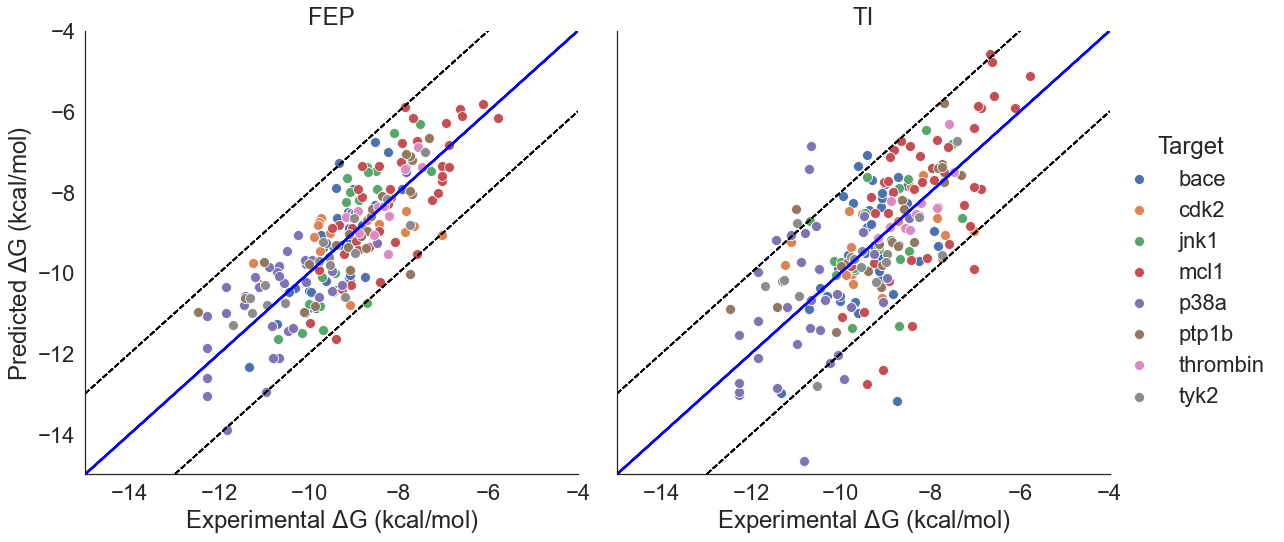

In [115]:
sns.set(font_scale=2)
sns.set_style("white")
g = sns.FacetGrid(mdf,col="Method",hue="Target",col_wrap=2,height=8,legend_out=True)
g.map(draw_dG_facet,"Experimental_dG","Predicted_dG",skip_text=True,s=100)
_ = g.set_titles(col_template="{col_name}")
g.set_xlabels("Experimental $\Delta$G (kcal/mol)")
g.set_ylabels("Predicted $\Delta$G (kcal/mol)")
_ = g.add_legend()

#### Trellising the Data
I think a better way to plot this data is to trellis by target/method and to put the plots side by side.  I also think it's important to display the $R^2$ for the correlations.

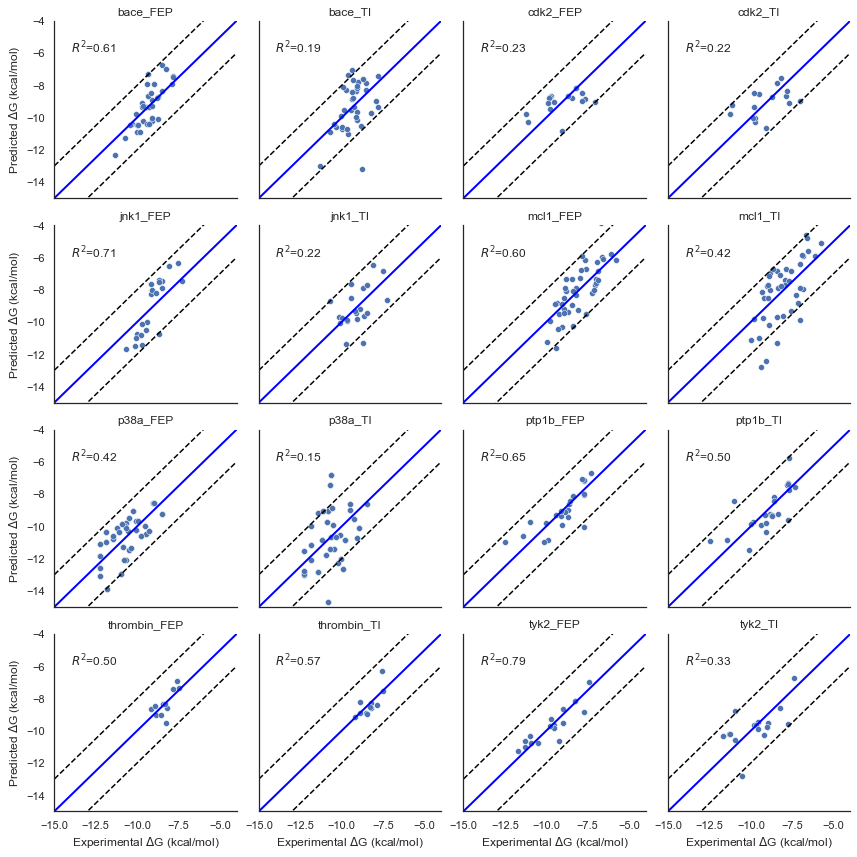

In [116]:
sns.set(font_scale=1)
sns.set_style("white")
g = sns.FacetGrid(mdf,col="DataSet",col_wrap=4)
g.map(draw_dG_facet,"Experimental_dG","Predicted_dG")
_ = g.set_titles(col_template="{col_name}")
g.set_xlabels("Experimental $\Delta$G (kcal/mol)")
_= g.set_ylabels("Predicted $\Delta$G (kcal/mol)")

#### Calculating Confidence Intervals for Correlation Coefficients
Another way to look at this data is to plot the correlations as bar plots.  Of course the bar plots should have error bars.  We can use this function to calculate the 95% confidence interval for the correlations. 

In [117]:
def pearson_confidence(r, num, interval=0.95):
    """
    Calculate upper and lower 95% CI for a Pearson r (not R**2)
    Inspired by https://stats.stackexchange.com/questions/18887
    :param r: Pearson's R
    :param num: number of data points
    :param interval: confidence interval (0-1.0)
    :return: lower bound, upper bound
    """
    stderr = 1.0 / math.sqrt(num - 3)
    interval = interval + (1-interval)/2
    z_score = norm.ppf(interval)
    delta = z_score * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return lower, upper

This code just calculates Pearson r for each of the target/method combinations.  I used the Pearson r rather than $R^2$ because I felt it made the differences more apparent in the plots.

In [118]:
gb = big_df.groupby("Target")
res = []
for k,v in gb:
    num = len(v.Experimental_dG)
    r_FEP = pearsonr(v.Experimental_dG,v.FEP_dG)[0]
    r_TI = pearsonr(v.Experimental_dG,v.TI_dG)[0]
    lb_FEP, ub_FEP = pearson_confidence(r_FEP,num)
    lb_TI, ub_TI = pearson_confidence(r_TI,num)
    # Currently calculate Pearson r, use the line below to get R**2
    #res.append([k,len(v)]+[x**2 for x in [lb_FEP,r_FEP,ub_FEP,lb_TI,r_TI,ub_TI]])
    res.append([k,len(v)]+[x for x in [lb_FEP,r_FEP,ub_FEP,lb_TI,r_TI,ub_TI]])
res_df = pd.DataFrame(res,columns=["Target","Num","FEP_LB","FEP Correlation","FEP_UB","TI_LB","TI Correlation","TI_UB"])

In [119]:
res_df

,Target,Num,FEP_LB,FEP Correlation,FEP_UB,TI_LB,TI Correlation,TI_UB
0,bace,36,0.61,0.78,0.88,0.12,0.43,0.67
1,cdk2,16,-0.03,0.48,0.79,-0.03,0.47,0.78
2,jnk1,21,0.65,0.84,0.94,0.05,0.47,0.75
3,mcl1,42,0.61,0.77,0.87,0.43,0.65,0.80
4,p38a,34,0.40,0.65,0.81,0.05,0.38,0.64
5,ptp1b,23,0.59,0.80,0.91,0.42,0.71,0.87
6,thrombin,11,0.18,0.71,0.92,0.28,0.76,0.93
7,tyk2,16,0.71,0.89,0.96,0.11,0.57,0.83


#### Plotting Correlations With Error Bars
In order to make the plots, we need to reshape the data.

In [120]:
melt_res_df = res_df[["Target","FEP Correlation","TI Correlation"]].melt(id_vars="Target")
melt_res_df.sort_values("Target",inplace=True)

In [121]:
melt_res_df

,Target,variable,value
0,bace,FEP Correlation,0.78
8,bace,TI Correlation,0.43
1,cdk2,FEP Correlation,0.48
9,cdk2,TI Correlation,0.47
2,jnk1,FEP Correlation,0.84
10,jnk1,TI Correlation,0.47
3,mcl1,FEP Correlation,0.77
11,mcl1,TI Correlation,0.65
4,p38a,FEP Correlation,0.65
12,p38a,TI Correlation,0.38


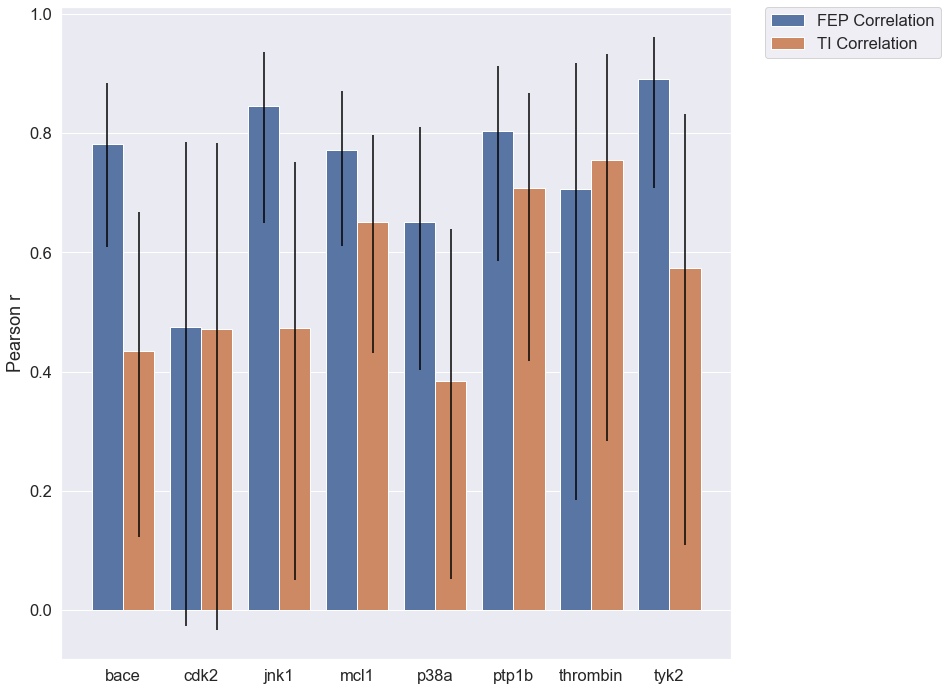

In [122]:
sns.set(rc={'figure.figsize':(12,12)},font_scale=1.5)
ax = sns.barplot(x="Target",y="value",hue="variable",data=melt_res_df)
x_pos = np.arange(8)-0.2
y_val = res_df["FEP Correlation"]
lb = y_val - res_df.FEP_LB
ub = res_df.FEP_UB - y_val
ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
x_pos = np.arange(8)+0.2
y_val = res_df["TI Correlation"]
lb = y_val - res_df.TI_LB
ub = res_df.TI_UB - y_val
a = ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=handles[0:2], labels=labels[0:2])
_ = ax.set(xlabel='', ylabel="Pearson r")

#### Calculating the Effect Size
As [Anthony Nicholls](https://link.springer.com/article/10.1007/s10822-016-9904-5) points out, when we have a data set like this with dependent errors, the fact that error bars overlap does not necessarily imply that the methods are equivalent.  However, we can use the mean of differences / std deviation of the differences to calculate [Cohen's d](https://machinelearningmastery.com/effect-size-measures-in-python/), which measures the effect size. Cohen’s d measures the difference between the mean from two Gaussian-distributed variables. It is a standard score that summarizes the difference in terms of the number of standard deviations. Because the score is standardized, there is a table for the interpretation of the result, summarized as:

- Small Effect Size: d=0.20
- Medium Effect Size: d=0.50
- Large Effect Size: d=0.80


In [123]:
delta = res_df["FEP Correlation"].values-res_df["TI Correlation"].values
np.mean(delta)/np.std(delta)

1.2137416942335348

We get a Cohen's d of 1.2, which is a very large effect size. We can define a function to convert d to an approximate probability between 0 and 1.

In [124]:
def d_to_probability(d):
    return 0.25 * abs(d) + 0.5 
d_to_probability(1.2)

0.8

So for the 8 datasets we examined, FEP should outperform TI in 8 of 10 cases. To look at this visually, let's plot a kernel density estimate for the Pearson r distributions. 

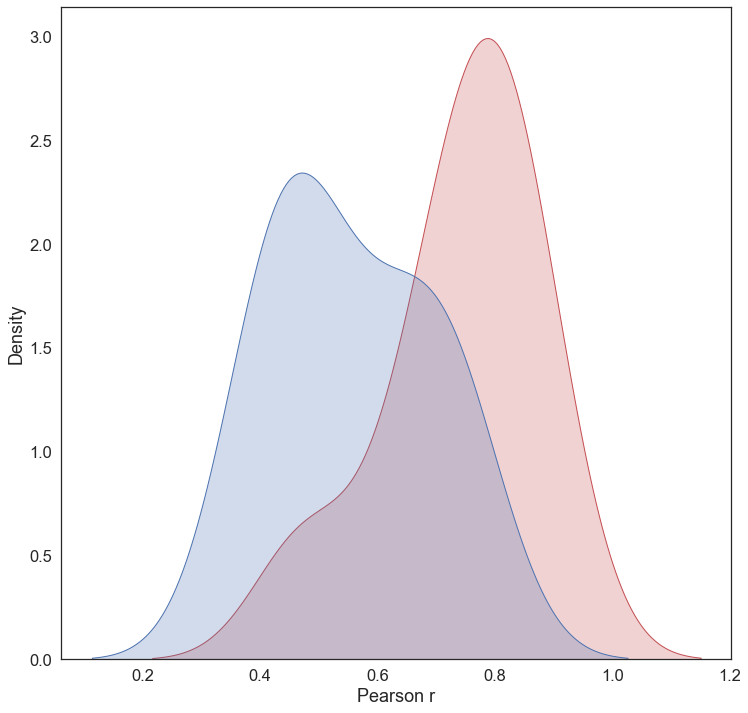

In [125]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.kdeplot(res_df["FEP Correlation"],color="r",shade=True)
ax = sns.kdeplot(res_df["TI Correlation"],color="b",shade=True)
_ = ax.set(xlabel="Pearson r",ylabel="Density")

We can also calculate Cohen's d for the RMSE.

In [131]:
gb = big_df.groupby("Target")
res = []
for k,v in gb:
    res.append([k,mean_squared_error(v.Experimental_dG,v.FEP_dG),mean_squared_error(v.Experimental_dG,v.TI_dG)])
rmse_df = pd.DataFrame(res,columns=["Target","FEP RMSE","TI RMSE"])

In [132]:
delta = rmse_df["FEP RMSE"].values - rmse_df["TI RMSE"].values
np.mean(delta)/np.std(delta)

-1.0813375331578456

Again we have a very large effect size. As above, we can covert this to a probability.

In [133]:
d_to_probability(-1.08)

0.77